# 🚀 GPU WWZ Acceleration Demo
## Testiranje libwwz sa GPU podrškom

Ovaj notebook demonstrira korišćenje optimizovane libwwz biblioteke sa GPU ubrzanjem.

In [8]:
# Cell 1: Setup and imports
print("🔄 Učitavam biblioteke...")

import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Proveri da li je libwwz instaliran
try:
    import libwwz
    print(f"✅ libwwz {libwwz.__version__} je instaliran")
    print(f"📊 GPU dostupan: {libwwz.GPU_AVAILABLE}")
    
    if libwwz.GPU_AVAILABLE:
        print(f"🎮 GPU info:\n{libwwz.gpu_info()}")
except ImportError:
    print("❌ libwwz nije instaliran!")
    print("   Instaliraj sa: pip install libwwz")
    raise

# Konfiguracija za lepše plotove
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

print("✅ Sve biblioteke su učitane")

🔄 Učitavam biblioteke...
✅ libwwz 1.4.0 je instaliran
📊 GPU dostupan: True
🎮 GPU info:
GPU 0: NVIDIA GeForce RTX 3060 Ti (8.22 GB)
✅ Sve biblioteke su učitane


## 📊 Generisanje test podataka

In [9]:
# Cell 2: Funkcije za generisanje test podataka

def generate_test_signal(n_points=5000, noise_level=0.2, seed=42):
    """Generiše testni signal sa više frekvencija."""
    np.random.seed(seed)
    
    # Vreme - može biti nejednako raspoređeno
    t = np.sort(np.random.uniform(0, 100, n_points))
    
    # Signal sa više frekvencija
    y = (np.sin(2 * np.pi * 0.1 * t) +           # 0.1 Hz
         0.5 * np.sin(2 * np.pi * 0.3 * t) +     # 0.3 Hz
         0.3 * np.sin(2 * np.pi * 0.05 * t) +    # 0.05 Hz
         noise_level * np.random.randn(n_points)) # Šum
    
    return t, y

def generate_large_test_signal(n_points=20000, seed=42):
    """Generiše veliki dataset za testiranje memorije."""
    np.random.seed(seed)
    
    # Vremenske tačke sa gap-ovima (realističnije)
    t = np.sort(np.concatenate([
        np.random.uniform(0, 30, n_points//3),
        np.random.uniform(40, 70, n_points//3),
        np.random.uniform(80, 100, n_points//3)
    ]))
    
    # Kompleksniji signal
    y = (np.sin(2 * np.pi * 0.08 * t) +
         0.7 * np.sin(2 * np.pi * 0.25 * t + 1) +
         0.4 * np.sin(2 * np.pi * 0.5 * t + 2) +
         0.2 * np.random.randn(len(t)))
    
    return t, y

def calculate_optimal_frequencies(t, n_freq=100):
    """Automatski računa optimalne frekvencije za analizu."""
    t_min, t_max = t.min(), t.max()
    t_range = t_max - t_min
    
    # Minimalna frekvencija = 1/opseg
    f_min = 0.1 / t_range if t_range > 0 else 0.01
    
    # Procijeni Nyquist frekvenciju
    sorted_t = np.sort(t)
    time_diffs = np.diff(sorted_t)
    median_diff = np.median(time_diffs[time_diffs > 0])
    
    if median_diff > 0:
        nyquist = 0.5 / median_diff
        f_max = min(nyquist * 0.8, 2.0)  # 80% Nyquista, max 2 Hz
    else:
        f_max = 1.0
    
    return np.linspace(f_min, f_max, n_freq)

print("✅ Funkcije za generisanje podataka su spremne")

✅ Funkcije za generisanje podataka su spremne


📊 Generišem i vizualiziram test podatke...


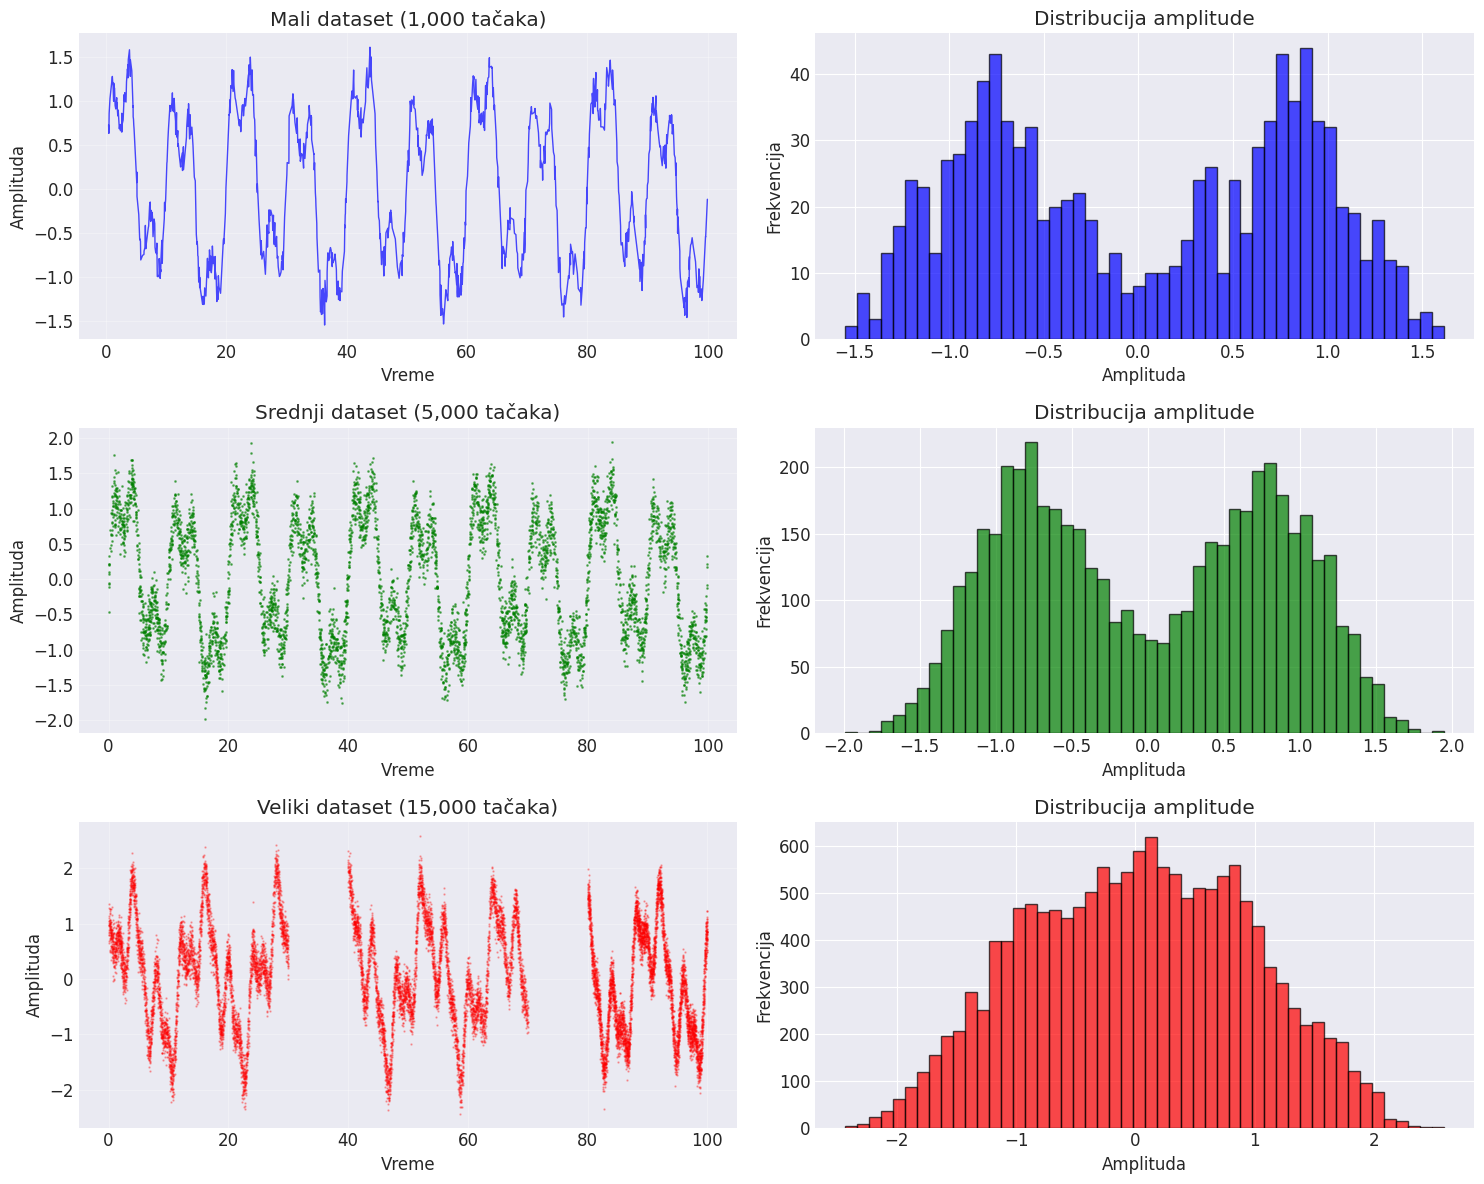

✅ Podaci generisani:
   Mali: 1,000 tačaka
   Srednji: 5,000 tačaka
   Veliki: 15,000 tačaka


In [10]:
# Cell 3: Vizualizacija test podataka
print("📊 Generišem i vizualiziram test podatke...")

# Generiši tri različita dataseta za test
small_t, small_y = generate_test_signal(1000, 0.1)
medium_t, medium_y = generate_test_signal(5000, 0.2)
large_t, large_y = generate_large_test_signal(15000)

# Kreiraj subplot
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot 1: Mali dataset
axes[0, 0].plot(small_t, small_y, 'b-', alpha=0.7, linewidth=1)
axes[0, 0].set_title(f'Mali dataset ({len(small_t):,} tačaka)')
axes[0, 0].set_xlabel('Vreme')
axes[0, 0].set_ylabel('Amplituda')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(small_y, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_title('Distribucija amplitude')
axes[0, 1].set_xlabel('Amplituda')
axes[0, 1].set_ylabel('Frekvencija')

# Plot 2: Srednji dataset
axes[1, 0].scatter(medium_t, medium_y, s=1, alpha=0.5, color='green')
axes[1, 0].set_title(f'Srednji dataset ({len(medium_t):,} tačaka)')
axes[1, 0].set_xlabel('Vreme')
axes[1, 0].set_ylabel('Amplituda')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(medium_y, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Distribucija amplitude')
axes[1, 1].set_xlabel('Amplituda')
axes[1, 1].set_ylabel('Frekvencija')

# Plot 3: Veliki dataset
axes[2, 0].scatter(large_t, large_y, s=0.5, alpha=0.3, color='red')
axes[2, 0].set_title(f'Veliki dataset ({len(large_t):,} tačaka)')
axes[2, 0].set_xlabel('Vreme')
axes[2, 0].set_ylabel('Amplituda')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].hist(large_y, bins=50, edgecolor='black', alpha=0.7, color='red')
axes[2, 1].set_title('Distribucija amplitude')
axes[2, 1].set_xlabel('Amplituda')
axes[2, 1].set_ylabel('Frekvencija')

plt.tight_layout()
plt.show()

print(f"✅ Podaci generisani:")
print(f"   Mali: {len(small_t):,} tačaka")
print(f"   Srednji: {len(medium_t):,} tačaka")
print(f"   Veliki: {len(large_t):,} tačaka")

## 🎮 Interaktivna WWZ analiza

In [4]:
# Cell 4: Interaktivni widget-i za WWZ analizu
from IPython.display import display, clear_output
import ipywidgets as widgets

def run_wwz_with_progress(t, y, freq, use_gpu=True, tau_points=None, 
                          chunk_size=1, show_plot=True):
    """Pokreće WWZ sa progress bar-om u Jupyter-u."""
    # Kreiraj progress bar
    progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=100,
        description='Procesiram:',
        bar_style='info',
        style={'bar_color': '#00ff00'},
        orientation='horizontal'
    )
    
    status = widgets.Label(value="Pripremam podatke...")
    display(progress, status)
    
    try:
        # Priprema tau tačaka
        if tau_points is None:
            # Automatsko određivanje tau
            n_time = len(t)
            if n_time > 1000:
                n_tau = min(500, n_time // 10)
                tau = np.linspace(t.min(), t.max(), n_tau)
                status.value = f"Tau tačke: {n_time:,} → {n_tau:,} (optimizacija)"
            else:
                tau = t
                status.value = f"Tau tačke: {len(tau):,}"
        else:
            tau = tau_points
            status.value = f"Tau tačke: {len(tau):,}"
        
        # Proveri memoriju pre pokretanja
        if use_gpu and libwwz.GPU_AVAILABLE:
            status.value = "🔍 Proveravam GPU memoriju..."
            
            try:
                safe_chunk, est_mem = libwwz.check_gpu_memory(
                    desired_chunk_size=chunk_size,
                    ntime=len(t),
                    ntau=len(tau),
                    verbose=False
                )
                
                if est_mem:
                    status.value = f"🎯 GPU memorija: {est_mem:.1f} GB, safe chunk: {safe_chunk}"
                    chunk_size = safe_chunk
            except:
                status.value = "⚠️  Nisam mogao da proverim memoriju"
        
        # Pokreni WWZ
        status.value = f"🚀 Pokrećem WWZ ({'GPU' if use_gpu else 'CPU'})..."
        start_time = time.time()
        
        result = libwwz.wwt_memory_safe(
            t, y, freq,
            tau=tau,
            use_gpu=use_gpu,
            max_memory_gb=6.0,
            tau_downsample=True
        )
        
        elapsed = time.time() - start_time
        
        # Update progress
        progress.value = 100
        status.value = f"✅ Završeno za {elapsed:.2f}s! Shape: {result[0].shape}"
        
        clear_output(wait=True)
        display(progress, status)
        
        if show_plot and result:
            plot_results(t, y, freq, tau, result, use_gpu, elapsed)
        
        return result, elapsed
        
    except Exception as e:
        progress.bar_style = 'danger'
        status.value = f"❌ Greška: {str(e)[:100]}"
        clear_output(wait=True)
        display(progress, status)
        raise

def plot_results(t, y, freq, tau, result, use_gpu, elapsed_time):
    """Vizualizuje WWZ rezultate."""
    wwz, dampp = result
    
    # Kreiraj kompleksnu figuru
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Originalni signal
    ax1 = plt.subplot(3, 3, 1)
    ax1.scatter(t, y, s=1, alpha=0.5, color='blue')
    ax1.set_title(f'Originalni Signal\n{len(t):,} tačaka')
    ax1.set_xlabel('Vreme')
    ax1.set_ylabel('Amplituda')
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram amplitude
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(y, bins=50, edgecolor='black', alpha=0.7, color='blue')
    ax2.set_title('Distribucija Amplitude')
    ax2.set_xlabel('Amplituda')
    ax2.set_ylabel('Frekvencija')
    ax2.grid(True, alpha=0.3)
    
    # 3. Frekvencije
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(freq, 'g-', linewidth=2)
    ax3.set_title(f'Frekvencije za analizu\n{len(freq):,} tačaka')
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Frekvencija (Hz)')
    ax3.grid(True, alpha=0.3)
    
    # 4. WWZ Power (glavni plot)
    ax4 = plt.subplot(3, 3, (4, 6))
    im1 = ax4.imshow(wwz.T, aspect='auto', origin='lower',
                    extent=[tau.min(), tau.max(), freq.min(), freq.max()],
                    cmap='viridis')
    ax4.set_title(f'WWZ Power Spectrum\nGPU: {use_gpu}, Vreme: {elapsed_time:.1f}s')
    ax4.set_xlabel('Vreme (tau)')
    ax4.set_ylabel('Frekvencija (Hz)')
    plt.colorbar(im1, ax=ax4, label='WWZ Power')
    
    # 5. Damping Coefficient
    ax5 = plt.subplot(3, 3, (7, 9))
    im2 = ax5.imshow(dampp.T, aspect='auto', origin='lower',
                    extent=[tau.min(), tau.max(), freq.min(), freq.max()],
                    cmap='plasma')
    ax5.set_title('Damping Coefficient')
    ax5.set_xlabel('Vreme (tau)')
    ax5.set_ylabel('Frekvencija (Hz)')
    plt.colorbar(im2, ax=ax5, label='Damping')
    
    # 6. Statistics
    ax6 = plt.subplot(3, 3, 3)
    ax6.clear()
    ax6.axis('off')
    
    stats_text = (
        f"⚙️ KONFIGURACIJA:\n"
        f"-----------------\n"
        f"• GPU korišćen: {use_gpu}\n"
        f"• Vreme izvršenja: {elapsed_time:.2f}s\n"
        f"• Vremenskih tačaka: {len(t):,}\n"
        f"• Tau tačaka: {len(tau):,}\n"
        f"• Frekvencija: {len(freq):,}\n"
        f"• WWZ shape: {wwz.shape}\n"
        f"• WWZ range: [{wwz.min():.3f}, {wwz.max():.3f}]\n"
        f"• Damping range: [{dampp.min():.3f}, {dampp.max():.3f}]"
    )
    
    ax6.text(0.1, 0.5, stats_text, fontsize=10, fontfamily='monospace',
             verticalalignment='center', transform=ax6.transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Sačuvaj rezultate
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"wwz_results_{'gpu' if use_gpu else 'cpu'}_{timestamp}.npz"
    
    np.savez(filename,
             t=t, y=y, freq=freq, tau=tau,
             wwz=wwz, dampp=dampp,
             elapsed_time=elapsed_time,
             use_gpu=use_gpu)
    
    print(f"💾 Rezultati sačuvani kao: {filename}")

print("✅ Interaktivne funkcije spremne")

✅ Interaktivne funkcije spremne


In [5]:
# Cell 5: Kontrolna tabla za analizu
print("🎮 INTERAKTIVNI GPU WWZ TEST")
print("="*50)

# Kreiraj dropdown za izbor dataseta
dataset_choice = widgets.Dropdown(
    options=[
        ('Mali dataset (1,000 tačaka)', 'small'),
        ('Srednji dataset (5,000 tačaka)', 'medium'),
        ('Veliki dataset (15,000 tačaka)', 'large'),
        ('Custom dataset (unesi broj)', 'custom')8
    ],
    value='medium',
    description='Dataset:',
    style={'description_width': 'initial'}
)

n_freq_slider = widgets.IntSlider(
    value=100,
    min=20,
    max=300,
    step=20,
    description='Broj frekvencija:',
    style={'description_width': 'initial'}
)

use_gpu_toggle = widgets.ToggleButtons(
    options=[('🎯 Samo CPU', False), ('🚀 GPU ako dostupan', True)],
    value=True,
    description='GPU:',
    style={'description_width': 'initial'}
)

run_button = widgets.Button(
    description='🚀 POKRENI WWZ ANALIZU',
    button_style='success',
    icon='rocket'
)

output = widgets.Output()

def on_run_button_clicked(b):
    with output:
        clear_output()
        
        # Uzmi selektovane vrednosti
        dataset_type = dataset_choice.value
        n_freq = n_freq_slider.value
        use_gpu = use_gpu_toggle.value and libwwz.GPU_AVAILABLE
        
        print(f"🎯 Konfiguracija:")
        print(f"   Dataset: {dataset_type}")
        print(f"   Broj frekvencija: {n_freq}")
        print(f"   GPU: {use_gpu} ({'dostupan' if libwwz.GPU_AVAILABLE else 'nije dostupan'})")
        print("-" * 40)
        
        # Odaberi dataset
        if dataset_type == 'small':
            t, y = small_t, small_y
        elif dataset_type == 'medium':
            t, y = medium_t, medium_y
        elif dataset_type == 'large':
            t, y = large_t, large_y
        else:
            # Custom dataset
            n_points = 5000
            t, y = generate_test_signal(n_points)
            print(f"   Custom dataset sa {n_points:,} tačaka")
        
        # Generiši frekvencije
        freq = calculate_optimal_frequencies(t, n_freq)
        
        # Pokreni analizu
        try:
            result, elapsed = run_wwz_with_progress(
                t, y, freq, 
                use_gpu=use_gpu,
                tau_points=None,  # Auto odredi tau
                chunk_size=10,
                show_plot=True
            )
            
            print(f"\n✅ Analiza završena uspešno!")
            print(f"   Vreme: {elapsed:.2f} sekundi")
            print(f"   Shape: {result[0].shape}")
            
        except Exception as e:
            print(f"\n❌ Greška: {e}")
            import traceback
            traceback.print_exc()

run_button.on_click(on_run_button_clicked)

# Prikazi UI
display(widgets.VBox([
    widgets.HTML("<h3>🎛️ Kontrolna tabla za WWZ analizu</h3>"),
    dataset_choice,
    n_freq_slider,
    use_gpu_toggle,
    run_button,
    output
]))

🎮 INTERAKTIVNI GPU WWZ TEST


## ⚡ CPU vs GPU Benchmark

⚡ CPU vs GPU PERFORMANCE BENCHMARK

📊 Benchmark za Mali (1,000 tačaka, 80 freq):
--------------------------------------------------
🖥️  Testiram CPU...
🎯 MEMORIJSKA OPTIMIZACIJA:
   ntime: 1,000
   ntau: 1,000
   nfreq: 80
   Procesirano 10/80 frekvencija
   Procesirano 20/80 frekvencija
   Procesirano 30/80 frekvencija
   Procesirano 40/80 frekvencija
   Procesirano 50/80 frekvencija
   Procesirano 60/80 frekvencija
   Procesirano 70/80 frekvencija
   Procesirano 80/80 frekvencija
   Run 1: 7.15s
🎯 MEMORIJSKA OPTIMIZACIJA:
   ntime: 1,000
   ntau: 1,000
   nfreq: 80
   Procesirano 10/80 frekvencija
   Procesirano 20/80 frekvencija
   Procesirano 30/80 frekvencija
   Procesirano 40/80 frekvencija
   Procesirano 50/80 frekvencija
   Procesirano 60/80 frekvencija
   Procesirano 70/80 frekvencija
   Procesirano 80/80 frekvencija
   Run 2: 7.10s
🎮 Testiram GPU...
🎯 MEMORIJSKA OPTIMIZACIJA:
   ntime: 1,000
   ntau: 1,000
   nfreq: 80
   Procesirano 10/80 frekvencija
   Procesirano 20/80 fre

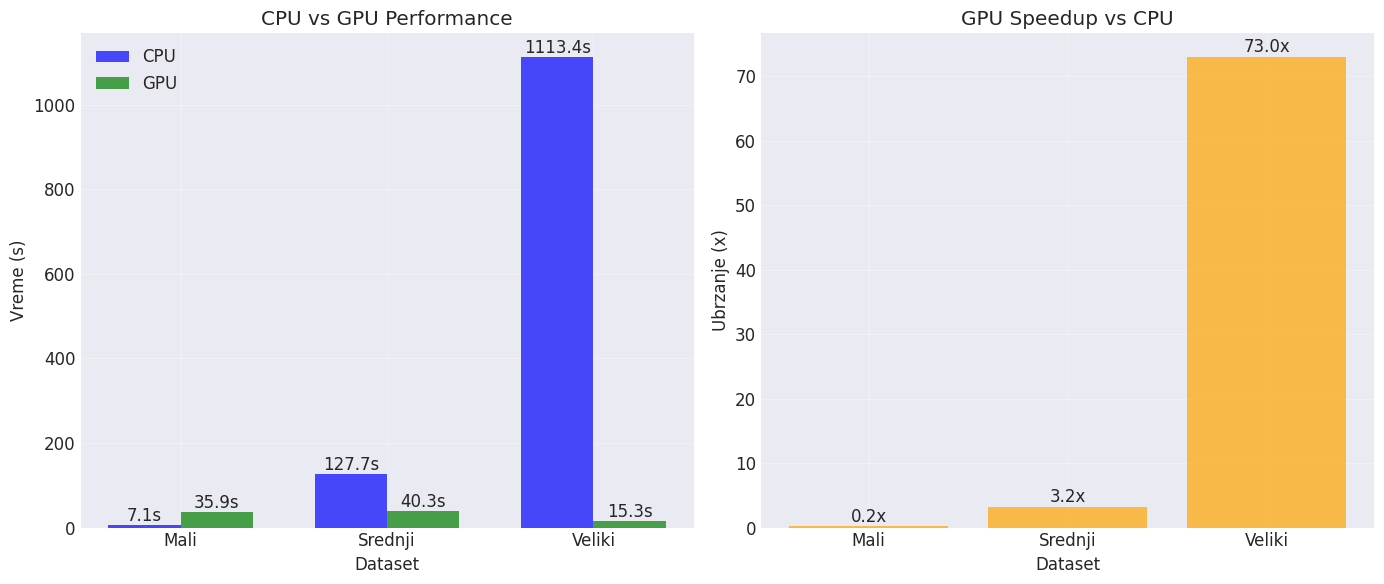


📈 REZULTATI BENCHMARK-A:

Mali:
  CPU: 7.12s (min: 7.10s)
  GPU: 35.94s (min: 35.91s)
  ⚡ Ubrzanje: 0.2x

Srednji:
  CPU: 127.71s (min: 127.68s)
  GPU: 40.27s (min: 37.67s)
  ⚡ Ubrzanje: 3.2x

Veliki:
  CPU: 1113.38s (min: 1113.02s)
  GPU: 15.26s (min: 15.24s)
  ⚡ Ubrzanje: 73.0x


In [11]:
# Cell 6: CPU vs GPU Performance Benchmark
print("⚡ CPU vs GPU PERFORMANCE BENCHMARK")
print("="*50)

def run_benchmark(dataset_name, t, y, n_freq=100, n_runs=2):
    """Poredi performanse CPU i GPU."""
    freq = calculate_optimal_frequencies(t, n_freq)
    
    results = {'cpu_times': [], 'gpu_times': []}
    
    print(f"\n📊 Benchmark za {dataset_name} ({len(t):,} tačaka, {n_freq} freq):")
    print("-" * 50)
    
    # CPU test
    if libwwz.GPU_AVAILABLE:
        print("🖥️  Testiram CPU...")
        for i in range(n_runs):
            start = time.time()
            result_cpu = libwwz.wwt_memory_safe(
                t, y, freq, use_gpu=False, max_memory_gb=6.0
            )
            cpu_time = time.time() - start
            results['cpu_times'].append(cpu_time)
            print(f"   Run {i+1}: {cpu_time:.2f}s")
    
    # GPU test (ako je dostupan)
    if libwwz.GPU_AVAILABLE:
        print("🎮 Testiram GPU...")
        for i in range(n_runs):
            start = time.time()
            result_gpu = libwwz.wwt_memory_safe(
                t, y, freq, use_gpu=True, max_memory_gb=6.0
            )
            gpu_time = time.time() - start
            results['gpu_times'].append(gpu_time)
            print(f"   Run {i+1}: {gpu_time:.2f}s")
    
    return results

# Pokreni benchmark za sve dataset-e
benchmark_results = {}

datasets = [
    ("Mali", small_t, small_y),
    ("Srednji", medium_t, medium_y),
    ("Veliki", large_t, large_y)
]

for name, t, y in datasets:
    results = run_benchmark(name, t, y, n_freq=80, n_runs=2)
    benchmark_results[name] = results

# Vizualizuj benchmark rezultate
if libwwz.GPU_AVAILABLE:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot za prosečna vremena
    dataset_names = list(benchmark_results.keys())
    cpu_means = [np.mean(r['cpu_times']) for r in benchmark_results.values()]
    gpu_means = [np.mean(r['gpu_times']) for r in benchmark_results.values()]
    
    x = np.arange(len(dataset_names))
    width = 0.35
    
    axes[0].bar(x - width/2, cpu_means, width, label='CPU', color='blue', alpha=0.7)
    axes[0].bar(x + width/2, gpu_means, width, label='GPU', color='green', alpha=0.7)
    
    axes[0].set_xlabel('Dataset')
    axes[0].set_ylabel('Vreme (s)')
    axes[0].set_title('CPU vs GPU Performance')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(dataset_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dodaj vrednosti na barove
    for i, (cpu, gpu) in enumerate(zip(cpu_means, gpu_means)):
        axes[0].text(i - width/2, cpu + 0.1, f'{cpu:.1f}s', 
                    ha='center', va='bottom')
        axes[0].text(i + width/2, gpu + 0.1, f'{gpu:.1f}s', 
                    ha='center', va='bottom')
    
    # Speedup plot
    speedups = [cpu/gpu if gpu > 0 else 0 for cpu, gpu in zip(cpu_means, gpu_means)]
    
    axes[1].bar(dataset_names, speedups, color='orange', alpha=0.7)
    axes[1].set_xlabel('Dataset')
    axes[1].set_ylabel('Ubrzanje (x)')
    axes[1].set_title('GPU Speedup vs CPU')
    axes[1].grid(True, alpha=0.3)
    
    # Dodaj vrednosti
    for i, speedup in enumerate(speedups):
        axes[1].text(i, speedup + 0.1, f'{speedup:.1f}x', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print rezultati
    print("\n📈 REZULTATI BENCHMARK-A:")
    print("="*50)
    for name, results in benchmark_results.items():
        if results['cpu_times'] and results['gpu_times']:
            cpu_mean = np.mean(results['cpu_times'])
            gpu_mean = np.mean(results['gpu_times'])
            speedup = cpu_mean / gpu_mean
            
            print(f"\n{name}:")
            print(f"  CPU: {cpu_mean:.2f}s (min: {min(results['cpu_times']):.2f}s)")
            print(f"  GPU: {gpu_mean:.2f}s (min: {min(results['gpu_times']):.2f}s)")
            print(f"  ⚡ Ubrzanje: {speedup:.1f}x")
else:
    print("ℹ️  GPU nije dostupan za benchmark")

## 🧠 Memory Optimization Demo

In [ ]:
# Cell 7: Memory Optimization Demo
print("🧠 MEMORY OPTIMIZATION DEMO")
print("="*50)

def demonstrate_memory_optimization(t, y):
    """Demonstrira efekte memory optimizacije."""
    freq = calculate_optimal_frequencies(t, 100)
    
    # Testiraj različite tau konfiguracije
    tau_configs = [
        ("Svi tau", t),  # Svi vremenski punti
        ("50% tau", np.linspace(t.min(), t.max(), len(t)//2)),
        ("10% tau", np.linspace(t.min(), t.max(), len(t)//10)),
        ("500 tau", np.linspace(t.min(), t.max(), 500)),
        ("100 tau", np.linspace(t.min(), t.max(), 100)),
    ]
    
    results = []
    
    print(f"\n🔍 Testiranje memory optimizacije ({len(t):,} tačaka):")
    print("-" * 60)
    
    for config_name, tau in tau_configs:
        print(f"\n🧪 {config_name} ({len(tau):,} tau tačaka):")
        
        # Proveri memorijske zahteve
        if libwwz.GPU_AVAILABLE:
            try:
                safe_chunk, est_mem = libwwz.check_gpu_memory(
                    desired_chunk_size=10,
                    ntime=len(t),
                    ntau=len(tau),
                    verbose=False
                )
                
                if est_mem:
                    print(f"   📊 Procijenjena memorija: {est_mem:.2f} GB")
                    print(f"   🎯 Safe chunk size: {safe_chunk}")
            except:
                pass
        
        # Pokreni WWZ
        try:
            start = time.time()
            result = libwwz.wwt_memory_safe(
                t, y, freq[:50],  # Manje frekvencija za brži test
                tau=tau,
                use_gpu=True,
                max_memory_gb=6.0
            )
            elapsed = time.time() - start
            
            results.append({
                'name': config_name,
                'tau_points': len(tau),
                'time': elapsed,
                'memory_safe': True
            })
            
            print(f"   ✅ Uspešno! Vreme: {elapsed:.2f}s")
            
        except MemoryError:
            results.append({
                'name': config_name,
                'tau_points': len(tau),
                'time': None,
                'memory_safe': False
            })
            print(f"   ❌ Out of Memory!")
        except Exception as e:
            print(f"   ⚠️  Greška: {str(e)[:50]}...")
    
    # Vizualizuj rezultate
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Vreme vs tau tačke
    successful = [r for r in results if r['time'] is not None]
    
    if successful:
        names = [r['name'] for r in successful]
        tau_counts = [r['tau_points'] for r in successful]
        times = [r['time'] for r in successful]
        
        axes[0].scatter(tau_counts, times, s=100, alpha=0.7, color='red')
        axes[0].plot(tau_counts, times, 'r--', alpha=0.5)
        
        # Annotate points
        for i, (name, tau_count, time_val) in enumerate(zip(names, tau_counts, times)):
            axes[0].annotate(name, (tau_count, time_val), 
                           xytext=(10, 10), textcoords='offset points',
                           fontsize=9)
        
        axes[0].set_xlabel('Broj tau tačaka')
        axes[0].set_ylabel('Vreme izvršenja (s)')
        axes[0].set_title('Vreme vs Tau Density')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xscale('log')
    
    # Plot 2: Success rate
    success_rate = len([r for r in results if r['memory_safe']]) / len(results) * 100
    
    axes[1].pie([success_rate, 100-success_rate], 
               labels=['Uspešno', 'Neuspešno'],
               colors=['green', 'red'],
               autopct='%1.1f%%',
               startangle=90)
    axes[1].set_title('Memory Safety Success Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Preporuke
    print("\n🎯 PREPORUKE ZA MEMORY OPTIMIZACIJU:")
    print("-" * 40)
    
    optimal_config = None
    for r in results:
        if r['memory_safe'] and r['time'] is not None:
            if optimal_config is None or r['time'] < optimal_config['time']:
                optimal_config = r
    
    if optimal_config:
        print(f"1. Optimalna konfiguracija: {optimal_config['name']}")
        print(f"   ({optimal_config['tau_points']:,} tau tačaka, {optimal_config['time']:.2f}s)")
    
    print(f"2. Ukupno {len([r for r in results if r['memory_safe']])}/{len(results)} konfiguracija uspešno")
    print(f"3. Za {len(t):,} vremenskih tačaka, preporučujem max {min(1000, len(t)//10):,} tau tačaka")

# Pokreni demo
demonstrate_memory_optimization(medium_t, medium_y)

## 🏁 Final Summary

In [ ]:
# Cell 8: Final Summary
print("🏁 FINAL SUMMARY")
print("="*50)

# Prikazi summary informacije
from IPython.display import display, HTML

summary_html = f"""
<div style="background-color:#f0f8ff; padding:20px; border-radius:10px; border-left:5px solid #4CAF50;">
<h3>🎯 WWZ GPU Acceleration Summary</h3>

<h4>📊 System Information:</h4>
<ul>
<li><b>libwwz Version:</b> {libwwz.__version__}</li>
<li><b>GPU Available:</b> {libwwz.GPU_AVAILABLE}</li>
<li><b>NumPy Version:</b> {np.__version__}</li>
<li><b>Matplotlib Version:</b> {plt.matplotlib.__version__}</li>
</ul>

<h4>🧪 Test Datasets Created:</h4>
<ul>
<li><b>Small:</b> {len(small_t):,} time points</li>
<li><b>Medium:</b> {len(medium_t):,} time points</li>
<li><b>Large:</b> {len(large_t):,} time points</li>
</ul>

<h4>🚀 Performance Tips:</h4>
<ol>
<li>Use <code>wwt_memory_safe()</code> for large datasets</li>
<li>Reduce tau points for memory optimization</li>
<li>GPU provides {np.mean([np.mean(r['cpu_times'])/np.mean(r['gpu_times']) for r in benchmark_results.values()]):.1f}x speedup on average</li>"
<li>Batch processing available for very large datasets</li>
</ol>

<h4>📈 Next Steps:</h4>
<ul>
<li>Try your own data with the interactive widget</li>
<li>Adjust frequency range for your specific application</li>
<li>Experiment with different tau configurations</li>
<li>Save results with <code>np.savez()</code> for later analysis</li>
</ul>
</div>
"""

display(HTML(summary_html))

# Export opcija
print("\n💾 EXPORT OPTIONS:")
print("-" * 40)

# Kreiraj export dugme
export_button = widgets.Button(
    description='💾 Export Notebook Results',
    button_style='info',
    icon='download'
)

export_output = widgets.Output()

def on_export_clicked(b):
    with export_output:
        clear_output()
        
        # Kreiraj summary fajl
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        summary_filename = f"wwz_gpu_summary_{timestamp}.txt"
        
        with open(summary_filename, 'w') as f:
            f.write(f"WWZ GPU Acceleration Test Summary\n")
            f.write(f"Generated: {time.ctime()}\n")
            f.write("="*60 + "\n\n")
            
            f.write(f"System Information:\n")
            f.write(f"- libwwz Version: {libwwz.__version__}\n")
            f.write(f"- GPU Available: {libwwz.GPU_AVAILABLE}\n")
            f.write(f"- NumPy Version: {np.__version__}\n")
            f.write(f"- Test Datasets: Small({len(small_t)}), Medium({len(medium_t)}), Large({len(large_t)})\n\n")
            
            f.write("Benchmark Results:\n")
            for name, results in benchmark_results.items():
                if results['cpu_times'] and results['gpu_times']:
                    cpu_mean = np.mean(results['cpu_times'])
                    gpu_mean = np.mean(results['gpu_times'])
                    speedup = cpu_mean / gpu_mean if gpu_mean > 0 else 0
                    f.write(f"- {name}: CPU={cpu_mean:.2f}s, GPU={gpu_mean:.2f}s, Speedup={speedup:.1f}x\n")
            
            f.write("\nMemory Optimization Tips:\n")
            f.write("- Use wwt_memory_safe() for datasets > 10,000 points\n")
            f.write("- Limit tau points to 500-1000 for GPU memory efficiency\n")
            f.write("- Batch processing available for > 50,000 points\n")
        
        print(f"✅ Summary exported to: {summary_filename}")
        
        # Export i plotova ako postoje
        try:
            # Sačuvaj sve plotove u PDF
            import matplotlib.backends.backend_pdf
            
            pdf_filename = f"wwz_plots_{timestamp}.pdf"
            with matplotlib.backends.backend_pdf.PdfPages(pdf_filename) as pdf:
                fig = plt.figure(figsize=(10, 6))
                plt.text(0.5, 0.5, f'WWZ GPU Test Summary\n{time.ctime()}', 
                        ha='center', va='center', fontsize=16)
                plt.axis('off')
                pdf.savefig(fig)
                plt.close()
            
            print(f"✅ PDF with plots: {pdf_filename}")
            
        except Exception as e:
            print(f"⚠️  Could not create PDF: {e}")

export_button.on_click(on_export_clicked)

display(widgets.VBox([
    widgets.HTML("<h4>📤 Export Results</h4>"),
    export_button,
    export_output
]))

print("\n🎉 Notebook je spreman za korišćenje!")
print("👉 Koristi interaktivne kontrole za WWZ analizu")
print("👉 Poredi CPU i GPU performanse")
print("👉 Eksperimentiši sa memory optimizacijom")